In [1]:
import re
import string
import warnings
from pathlib import Path
from time import time
from typing import Dict, List, Optional, Tuple

import arviz as az
import common_data_processing as dphelp
import matplotlib.colors as mcolors
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import plotnine as gg
import pymc3 as pm
import pymc3_helpers as pmhelp
import seaborn as sns
import string_functions as stringr
from custom_pymc3_callbacks import DivergenceFractionCallback
from plotnine_helpers import margin
from theano import tensor as tt

notebook_tic = time()

warnings.simplefilter(action="ignore", category=UserWarning)

gg.theme_set(gg.theme_minimal())
%config InlineBackend.figure_format = "retina"

RANDOM_SEED = 332
np.random.seed(RANDOM_SEED)

pymc3_cache_dir = Path("pymc3_model_cache")

## Data preparation (coppied)

In [2]:
data_path = Path("../modeling_data/depmap_modeling_dataframe_subsample.csv")
data = pd.read_csv(data_path)

data = data.sort_values(["hugo_symbol", "sgrna", "depmap_id"]).reset_index(drop=True)
for col in ("hugo_symbol", "depmap_id", "sgrna", "lineage", "chromosome"):
    data = dphelp.make_cat(data, col, ordered=True, sort_cats=False)

data["log2_cn"] = np.log2(data.gene_cn + 1)
data = dphelp.zscale_cna_by_group(
    data, gene_cn_col="log2_cn", new_col="z_log2_cn", cn_max=np.log2(10)
)
data["is_mutated"] = dphelp.nmutations_to_binary_array(data.n_muts)

---

### Model 7. Introduce a covariate for the KRAS allele to model 6

Finally, we can add a categorical variable for the *KRAS* allele of a tumor sample.

$
y \sim \mathcal{N}(\mu, \sigma) \\
\mu = \alpha_s + \gamma_g M + \delta_g \log_2 C + \epsilon_g K\\
\quad \alpha_s \sim \mathcal{N}(\mu_{\alpha_s}, \sigma_{\alpha_s}) \\
\qquad \mu_{\alpha_s} = g_s \\ 
\qquad \quad g_s \sim \mathcal{N}(\mu_g, \sigma_g) \\ 
\qquad \qquad \mu_g \sim \mathcal{N}(0, 5) \quad \sigma_g \sim \text{Exp}(1) \\ 
\qquad \sigma_\alpha \sim \text{Exp}(1) \\ 
\quad \gamma_g \sim \mathcal{N}(\mu_{\gamma_g}, \sigma_{\gamma_g}) \\ 
\qquad \mu_{\gamma_g} \sim \mathcal{N}(0, 2) \\ 
\qquad \sigma_{\gamma_g} \sim \text{HalfNormal}(2) \\ 
\quad \delta_g \sim \mathcal{N}(\mu_{\delta_g}, \sigma_{\delta_g}) \\ 
\qquad \mu_{\delta_g} \sim \mathcal{N}(-0.2, 2) \\ 
\qquad \sigma_{\delta_g} \sim \text{HalfNormal}(2) \\ 
\quad \epsilon_g \sim \mathcal{N}(\mu_{\epsilon_g}, \sigma_{\epsilon_g}) \\ 
\qquad \mu_{\epsilon_g} \sim \mathcal{N}(0, 0.5) \\ 
\qquad \sigma_{\epsilon_g} \sim \text{Exponential}(1) \\ 
\sigma \sim \text{HalfNormal}(5)
$

In [3]:
# List of KRAS alleles to keep separate. The rest will be "other".
MIN_KRAS_ALLELE_COUNT = 10

kras_counts = pd.get_dummies(
    data[["depmap_id", "kras_mutation"]].drop_duplicates()[["kras_mutation"]]
)
alleles_to_keep = (
    kras_counts.sum().index.values[kras_counts.sum() >= MIN_KRAS_ALLELE_COUNT].tolist()
)
alleles_to_keep = [a.replace("kras_mutation_", "") for a in alleles_to_keep]
print(f"Using the following alleles ({len(alleles_to_keep)})")
print(alleles_to_keep)

# Dummy matrix for the alleles.
data = data.assign(
    kras_mutation_idx=lambda d: [
        a if a in alleles_to_keep else "other" for a in d.kras_mutation
    ]
)
data = dphelp.make_cat(data, "kras_mutation_idx")
kras_dummy_matrix = np.array(pd.get_dummies(data[["kras_mutation_idx"]]))

Using the following alleles (4)
['G12C', 'G12D', 'G12V', 'WT']


In [4]:
gene_idx, num_genes = dphelp.get_indices_and_count(data, "hugo_symbol")
sgrna_idx, num_sgrnas = dphelp.get_indices_and_count(data, "sgrna")
kras_idx, num_kras = dphelp.get_indices_and_count(data, "kras_mutation_idx")

sgrna_to_gene_map = data[["sgrna", "hugo_symbol"]].drop_duplicates()
sgrna_gene_idx = dphelp.get_indices(sgrna_to_gene_map, "hugo_symbol")

In [49]:
with pm.Model() as m7:
    # Indices
    sgrna_gene_idx_shared = pm.Data("sgrna_gene_idx_shared", sgrna_gene_idx)
    sgrna_idx_shared = pm.Data("sgrna_idx_shared", sgrna_idx)
    gene_idx_shared = pm.Data("gene_idx_shared", gene_idx)
    kras_idx_shared = pm.Data("kras_idx_shared", kras_idx)

    # Data
    is_mutated_shared = pm.Data(
        "is_mutated_shared", dphelp.extract_flat_ary(data.is_mutated)
    )
    scaled_log2_cn_shared = pm.Data(
        "scaled_log2_cn_shared", dphelp.extract_flat_ary(data.z_log2_cn)
    )
    lfc_shared = pm.Data("lfc_shared", dphelp.extract_flat_ary(data.lfc))

    μ_g = pm.Normal("μ_g", 0, 1)
    σ_g = pm.HalfNormal("σ_g", 1)

    g_s = pm.Normal("g_s", μ_g, σ_g, shape=num_genes)

    μ_α_s = pm.Deterministic("μ_α_s", g_s[sgrna_gene_idx_shared])
    σ_α_s = pm.Exponential("σ_α_s", 2)
    μ_γ_g = pm.Normal("μ_γ_g", 0, 1)
    σ_γ_g = pm.Exponential("σ_γ_g", 2)
    μ_δ_g = pm.Normal("μ_δ_g", -0.2, 2)
    σ_δ_g = pm.Exponential("σ_δ_g", 2)
    μ_ϵ_g = pm.Normal("μ_ϵ_g", 0, 0.2)
    σ_ϵ_g = pm.Exponential("σ_ϵ_g", 5)

    α_s = pm.Normal("α_s", μ_α_s, σ_α_s, shape=num_sgrnas)
    γ_g = pm.Normal("γ_g", μ_γ_g, σ_γ_g, shape=num_genes)
    δ_g = pm.Normal("δ_g", μ_δ_g, σ_δ_g, shape=num_genes)
    ϵ_gk = pm.Normal("ϵ_gk", μ_ϵ_g, σ_ϵ_g, shape=(num_genes, num_kras))

    μ = pm.Deterministic(
        "μ",
        α_s[sgrna_idx_shared]
        + γ_g[gene_idx_shared] * is_mutated_shared
        + δ_g[gene_idx_shared] * scaled_log2_cn_shared
        + ϵ_gk[gene_idx_shared, kras_idx_shared],
    )
    σ = pm.HalfNormal("σ", 5)

    y = pm.Normal("y", μ, σ, observed=lfc_shared)

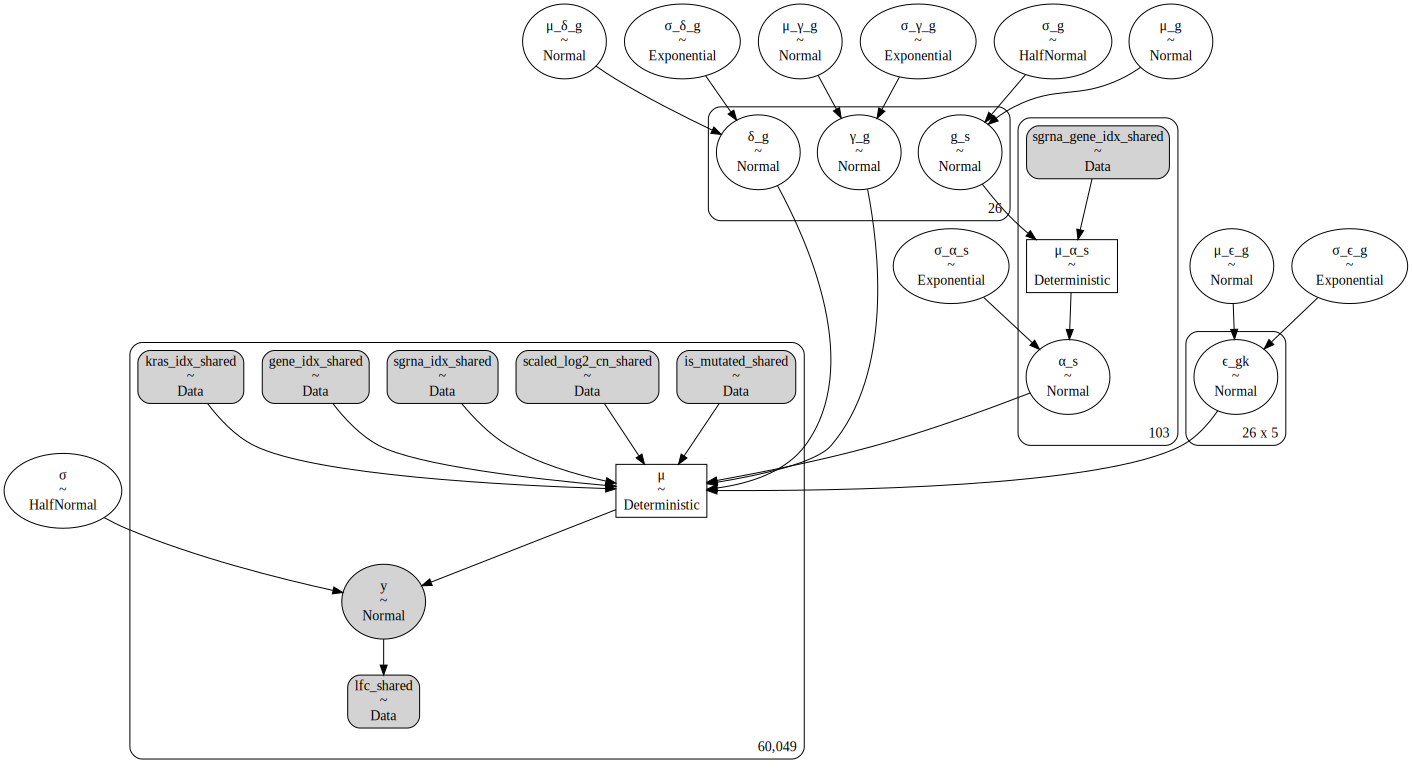

In [50]:
pm.model_to_graphviz(m7)

In [51]:
with m7:
    m7_prior_predictive = pm.sample_prior_predictive(
        samples=500, random_seed=RANDOM_SEED
    )

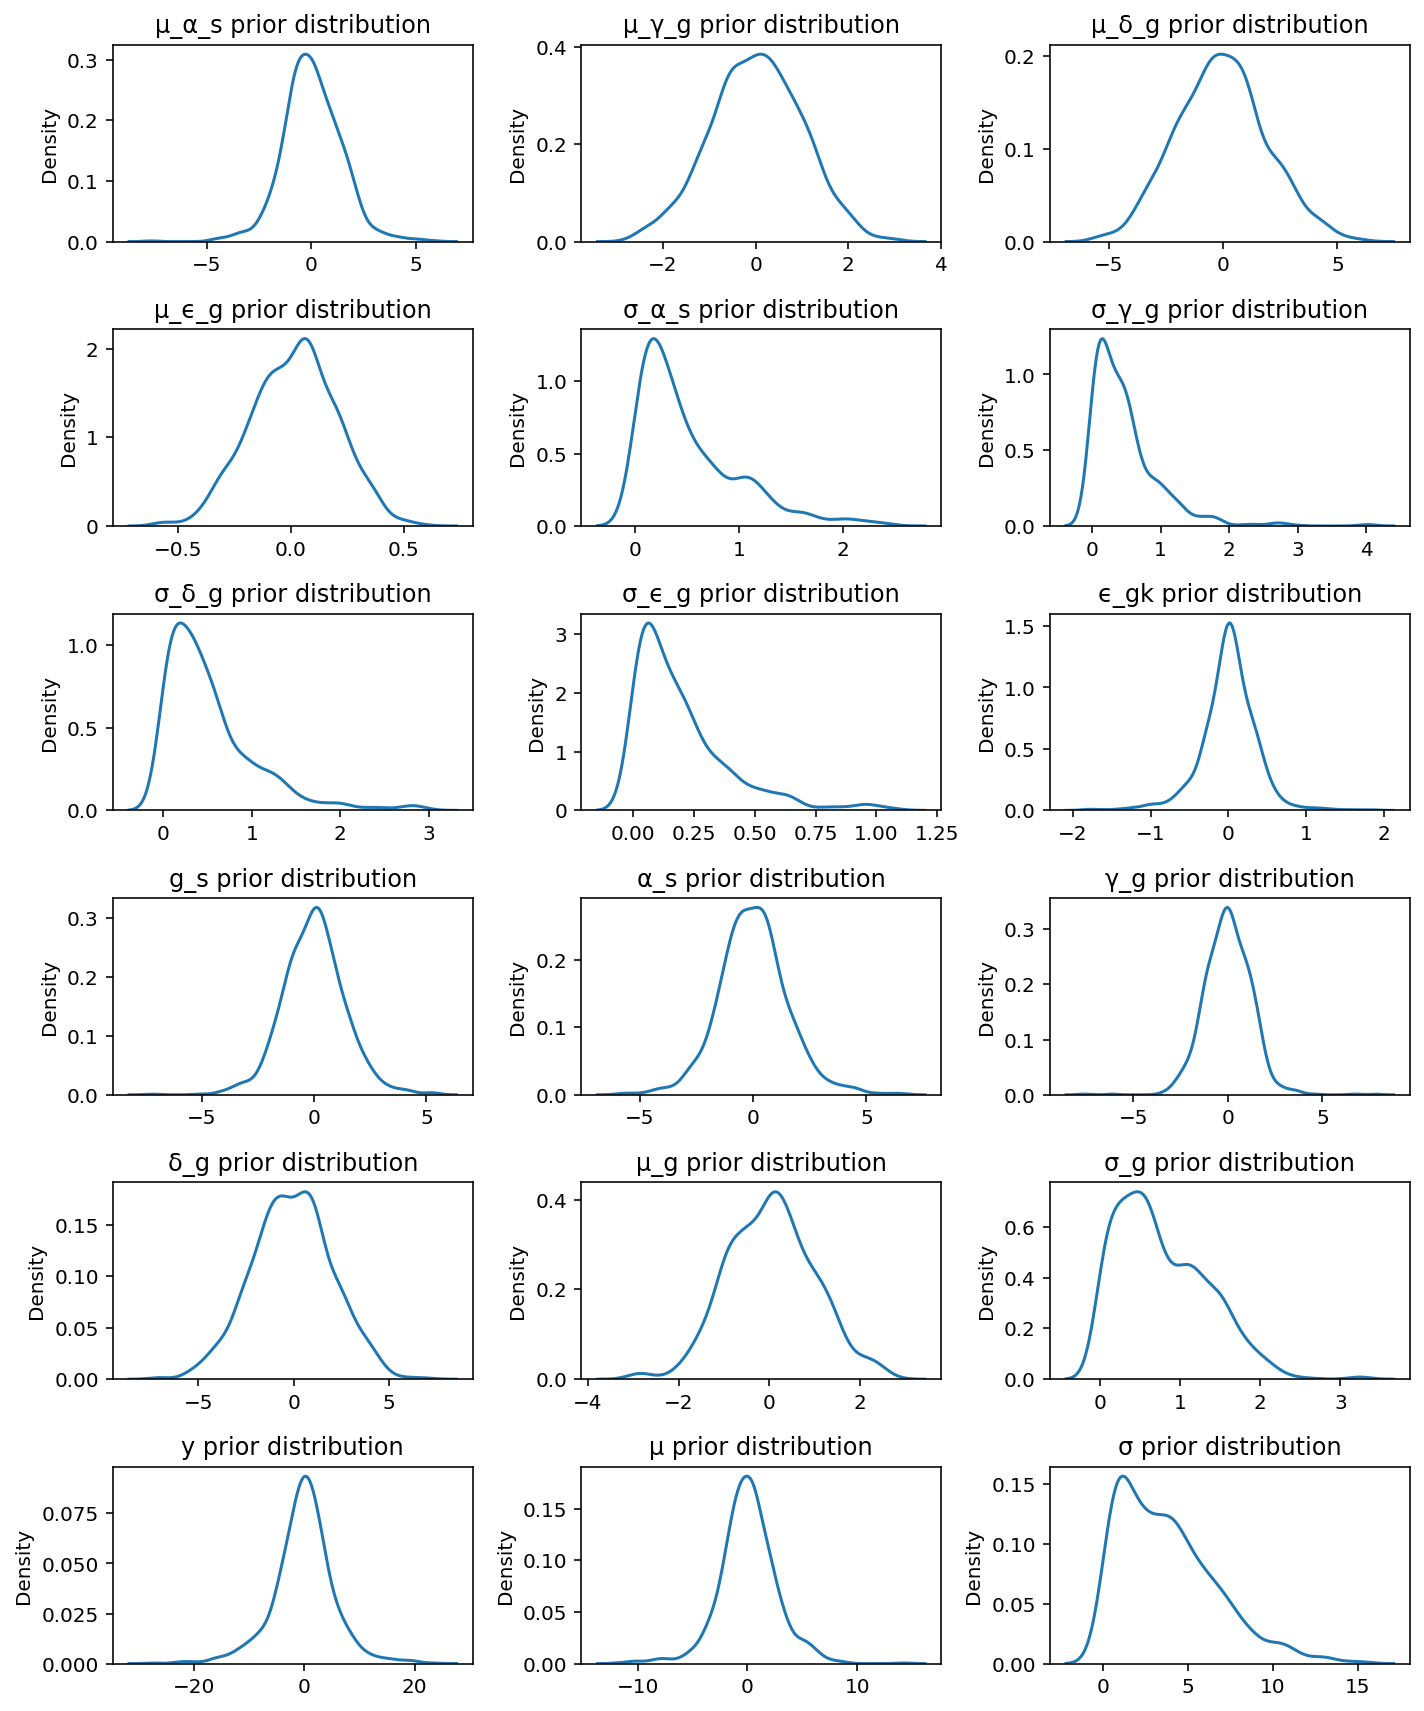

In [52]:
m7_vars: List[str] = []
for x in m7_prior_predictive.keys():
    if not "log__" in x:
        m7_vars.append(x)

m7_vars.sort()
m7_vars.sort(key=lambda x: -len(x))

fig, axes = plt.subplots(6, 3, figsize=(10, 12))
for var, ax in zip(m7_vars, axes.flatten()):
    sns.kdeplot(x=np.random.choice(m7_prior_predictive[var].flatten(), 1000), ax=ax)
    ax.set_title(f"{var} prior distribution")

fig.tight_layout()
plt.show()

In [85]:
class DivergenceCountingCallback:
    def __init__(self, max_divergences: int = 50) -> None:
        self.max_divergences = max_divergences
        self.divergence_count: int = 0
        self.draw_dict: Dict[int, pm.parallel_sampling.Draw] = {}
        self.trace_dict: Dict[int, pm.backends.ndarray.NDArray] = {}

    def __call__(
        self, trace: pm.backends.ndarray.NDArray, draw: pm.parallel_sampling.Draw
    ) -> None:
        if draw.tuning:
            return

        if len(trace) > 40:
            self.draw_dict[draw.chain] = draw
            self.trace_dict[draw.chain] = trace
            if len(self.draw_dict.keys()) > 2:
                raise KeyboardInterrupt("JHC")


#         if draw.stats[0]["diverging"]:
#             self.divergence_count += 1
#             if self.divergence_count >= self.max_divergences:
#                 raise KeyboardInterrupt(f"Too many divergences: {self.divergence_count} - stopping early")

In [113]:
m7_cache_dir = pymc3_cache_dir / "subset_speclet_m7"

N_TUNE_STEPS = 1000

# divergence_callback = DivergenceCountingCallback(50)
divergence_callback = DivergenceFractionCallback(
    n_tune_steps=N_TUNE_STEPS, max_frac=0.02, min_samples=100
)

m7_sampling_results = pmhelp.pymc3_sampling_procedure(
    model=m7,
    num_mcmc=2000,
    tune=N_TUNE_STEPS,
    chains=3,
    cores=3,
    random_seed=RANDOM_SEED,
    cache_dir=pymc3_cache_dir / m7_cache_dir,
    force=True,
    sample_kwargs={"callback": divergence_callback},
    #     sample_kwargs={"init": "advi+adapt_diag", "n_init": 40000, "callback": divergence_callback},
)

m7_az = pmhelp.samples_to_arviz(model=m7, res=m7_sampling_results)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (3 chains in 3 jobs)
NUTS: [σ, ϵ_gk, δ_g, γ_g, α_s, σ_ϵ_g, μ_ϵ_g, σ_δ_g, μ_δ_g, σ_γ_g, μ_γ_g, σ_α_s, g_s, σ_g, μ_g]


Sampling 2 chains for 1_000 tune and 84 draw iterations (2_000 + 168 draws total) took 738 seconds.
The rhat statistic is larger than 1.4 for some parameters. The sampler did not converge.
The number of effective samples is smaller than 10% for some parameters.


Caching trace and posterior sample...


posterior predictive variable y's shape not compatible with number of chains and draws. This can mean that some draws or even whole chains are not represented.


The only two high-level parameters with Rhat > 1.00 and very small ESS were `μ_g` and `μ_ϵ_g`. 
This is likely because there is too much non-identifiability between the two covariates $\alpha_s$ and $\epsilon_{gk}$.

In [114]:
az.summary(
    m7_az,
    var_names=["σ", "μ_g", "σ_g", "μ_γ_g", "σ_γ_g", "μ_δ_g", "σ_δ_g", "μ_ϵ_g", "σ_ϵ_g"],
    hdi_prob=0.89,
)

,mean,sd,hdi_5.5%,hdi_94.5%,mcse_mean,mcse_sd,ess_mean,ess_sd,ess_bulk,ess_tail,r_hat
σ,0.444,0.001,0.442,0.446,0.001,0.000,5.0,5.0,4.0,16.0,1.43
μ_g,-0.119,0.081,-0.240,0.005,0.045,0.035,3.0,3.0,3.0,15.0,1.77
σ_g,0.256,0.042,0.208,0.317,0.007,0.005,38.0,38.0,38.0,109.0,1.03
μ_γ_g,-0.084,0.050,-0.185,-0.019,0.004,0.006,148.0,33.0,72.0,108.0,1.26
σ_γ_g,0.262,0.055,0.199,0.331,0.029,0.022,4.0,4.0,3.0,17.0,1.69
μ_δ_g,-0.048,0.011,-0.067,-0.032,0.001,0.001,84.0,52.0,80.0,78.0,1.23
σ_δ_g,0.056,0.007,0.046,0.065,0.002,0.001,19.0,19.0,18.0,105.0,1.18
μ_ϵ_g,0.066,0.059,-0.000,0.168,0.037,0.030,3.0,3.0,3.0,13.0,2.11
σ_ϵ_g,0.067,0.005,0.060,0.077,0.001,0.001,16.0,16.0,14.0,108.0,1.23


In [39]:
def extract_gene_kras_indices(d: pd.DataFrame) -> pd.DataFrame:
    indices_list = [
        [int(x) for x in re.findall("[0-9]+", s)] for s in d.variable.values
    ]
    indices_array = np.asarray(indices_list)
    d["hugo_symbol_idx"] = indices_array[:, 0]
    d["kras_mutation_idx"] = indices_array[:, 1]
    return d


m7_epsilon_summary = (
    az.summary(m7_az, var_names="ϵ_gk", hdi_prob=0.89)
    .reset_index()
    .rename(columns={"index": "variable"})
    .pipe(extract_gene_kras_indices)
    .assign(
        hugo_symbol=lambda d: [
            data.hugo_symbol.values.categories[i] for i in d.hugo_symbol_idx
        ],
        kras_mutation=lambda d: [
            data.kras_mutation_idx.values.categories[i] for i in d.kras_mutation_idx
        ],
    )
)

In [40]:
m7_epsilon_summary.head()

,variable,mean,sd,hdi_5.5%,hdi_94.5%,mcse_mean,mcse_sd,ess_mean,ess_sd,ess_bulk,ess_tail,r_hat,hugo_symbol_idx,kras_mutation_idx,hugo_symbol,kras_mutation
0,"ϵ_gk[0,0]",0.077,0.155,-0.116,0.348,0.039,0.028,16.0,16.0,14.0,52.0,1.12,0,0,ADAMTS13,G12D
1,"ϵ_gk[0,1]",0.112,0.154,-0.091,0.370,0.039,0.031,16.0,13.0,14.0,56.0,1.13,0,1,ADAMTS13,WT
2,"ϵ_gk[0,2]",0.069,0.156,-0.139,0.327,0.039,0.028,16.0,16.0,14.0,53.0,1.12,0,2,ADAMTS13,G12V
3,"ϵ_gk[0,3]",0.067,0.162,-0.160,0.333,0.037,0.027,19.0,19.0,18.0,62.0,1.10,0,3,ADAMTS13,Q61H
4,"ϵ_gk[0,4]",0.122,0.159,-0.102,0.383,0.038,0.031,17.0,14.0,16.0,59.0,1.11,0,4,ADAMTS13,G12R


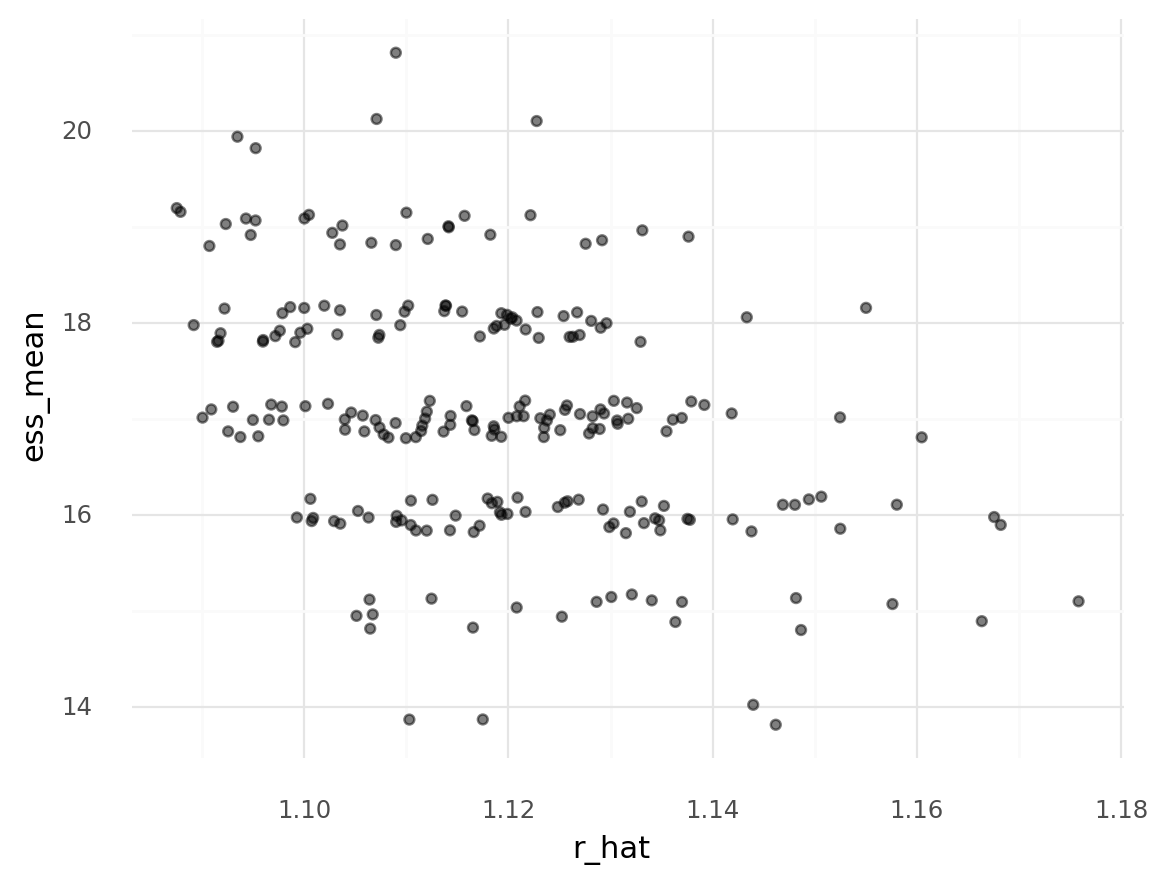

<ggplot: (8769626831041)>

In [45]:
(
    gg.ggplot(m7_epsilon_summary, gg.aes(x="r_hat", y="ess_mean"))
    + gg.geom_jitter(width=0.02, height=0.2, alpha=0.5)
)

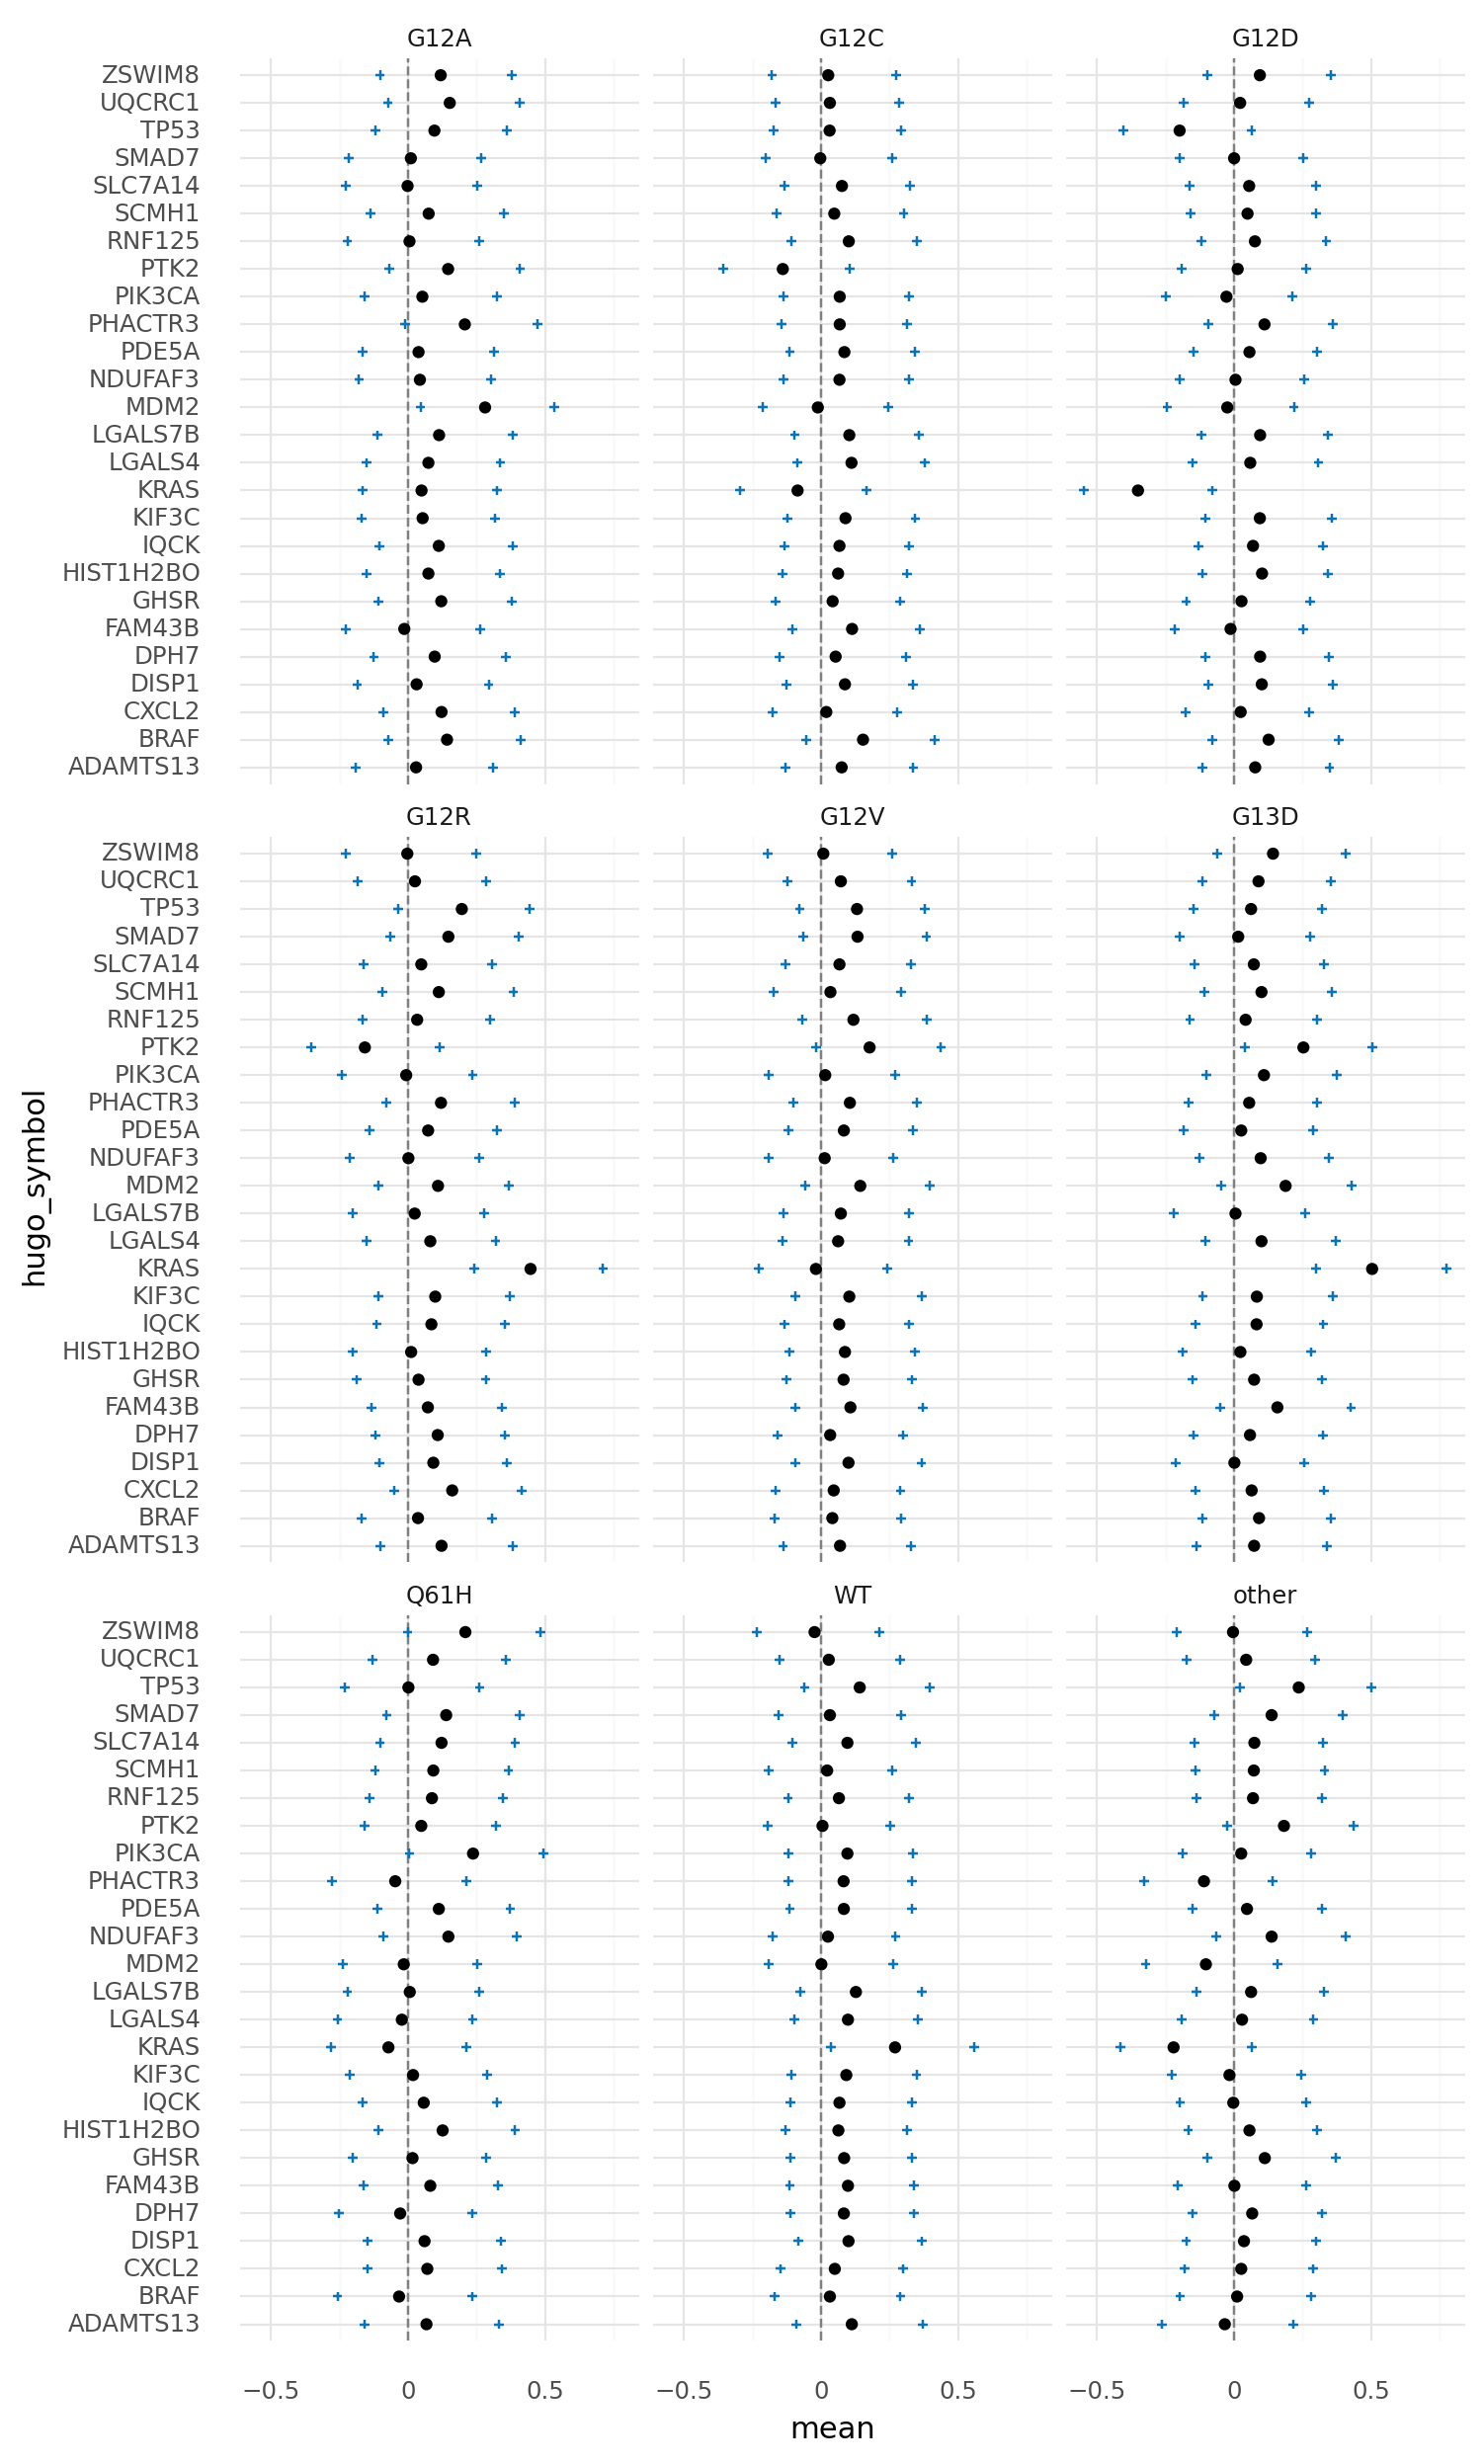

<ggplot: (8769616517464)>

In [50]:
(
    gg.ggplot(m7_epsilon_summary, gg.aes(x="mean", y="hugo_symbol"))
    + gg.facet_wrap("kras_mutation", ncol=3)
    + gg.geom_vline(xintercept=0, linetype="--", color="grey")
    + gg.geom_point(gg.aes(x="hdi_5.5%"), shape="+", color="#0D72B4")
    + gg.geom_point(gg.aes(x="hdi_94.5%"), shape="+", color="#0D72B4")
    + gg.geom_point()
    + gg.theme(figure_size=(8, 15))
)

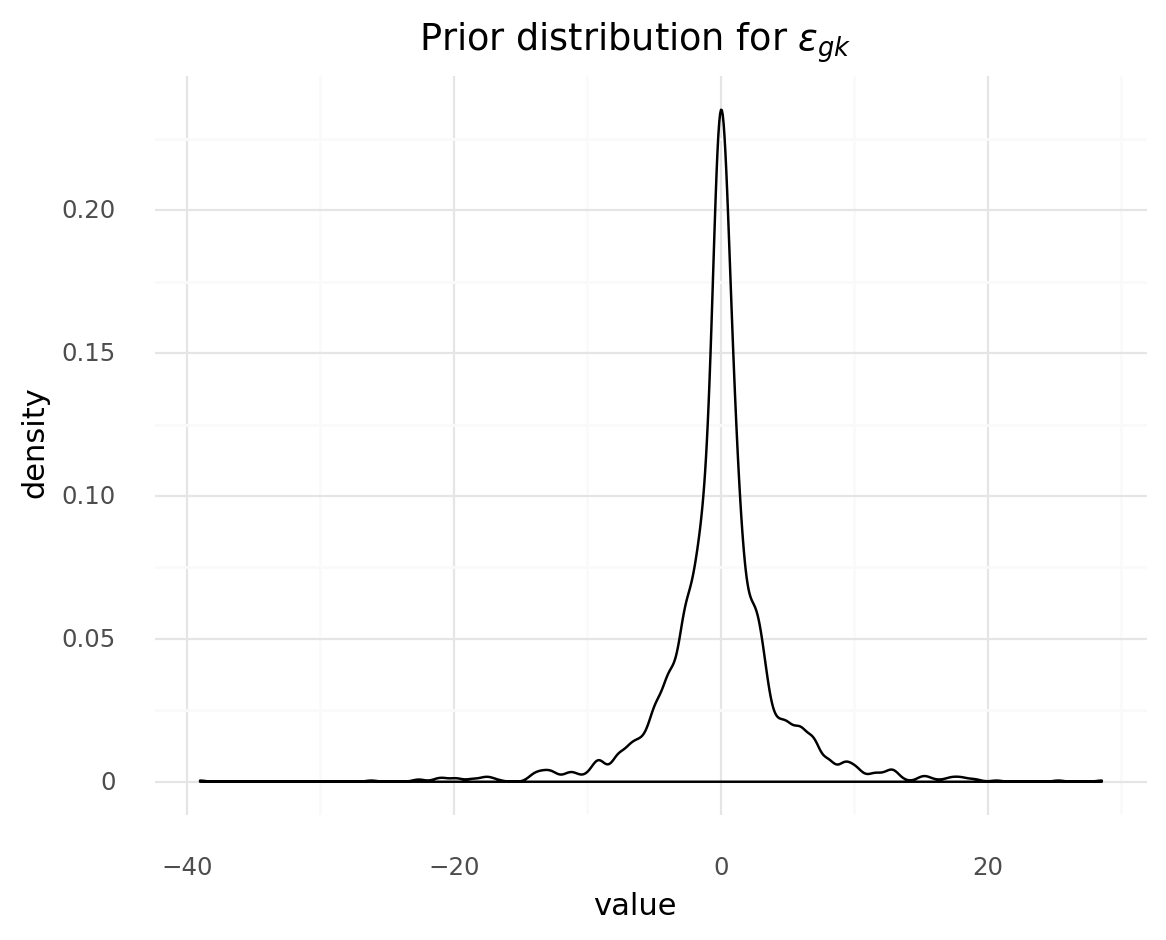

<ggplot: (8770084454897)>

In [115]:
def make_tidy_epsilon_gk(
    eps_trace: np.ndarray, original_data: pd.DataFrame
) -> pd.DataFrame:
    tidy_df = pd.DataFrame()
    for kras_allele_i in range(eps_trace.shape[2]):
        for gene_i in range(eps_trace.shape[1]):
            d = pd.DataFrame(
                {
                    "hugo_symbol": original_data.hugo_symbol.values.categories[gene_i],
                    "kras_mutation": original_data.kras_mutation_idx.values.categories[
                        kras_allele_i
                    ],
                    "value": eps_trace[:, gene_i, kras_allele_i],
                }
            )
            tidy_df = pd.concat([tidy_df, d])
    return tidy_df

In [100]:
m7_epsilon_post = m7_sampling_results["trace"]["ϵ_gk"][:100, :, :]
m7_epslion_tidy = make_tidy_epsilon_gk(m7_epsilon_post, data)

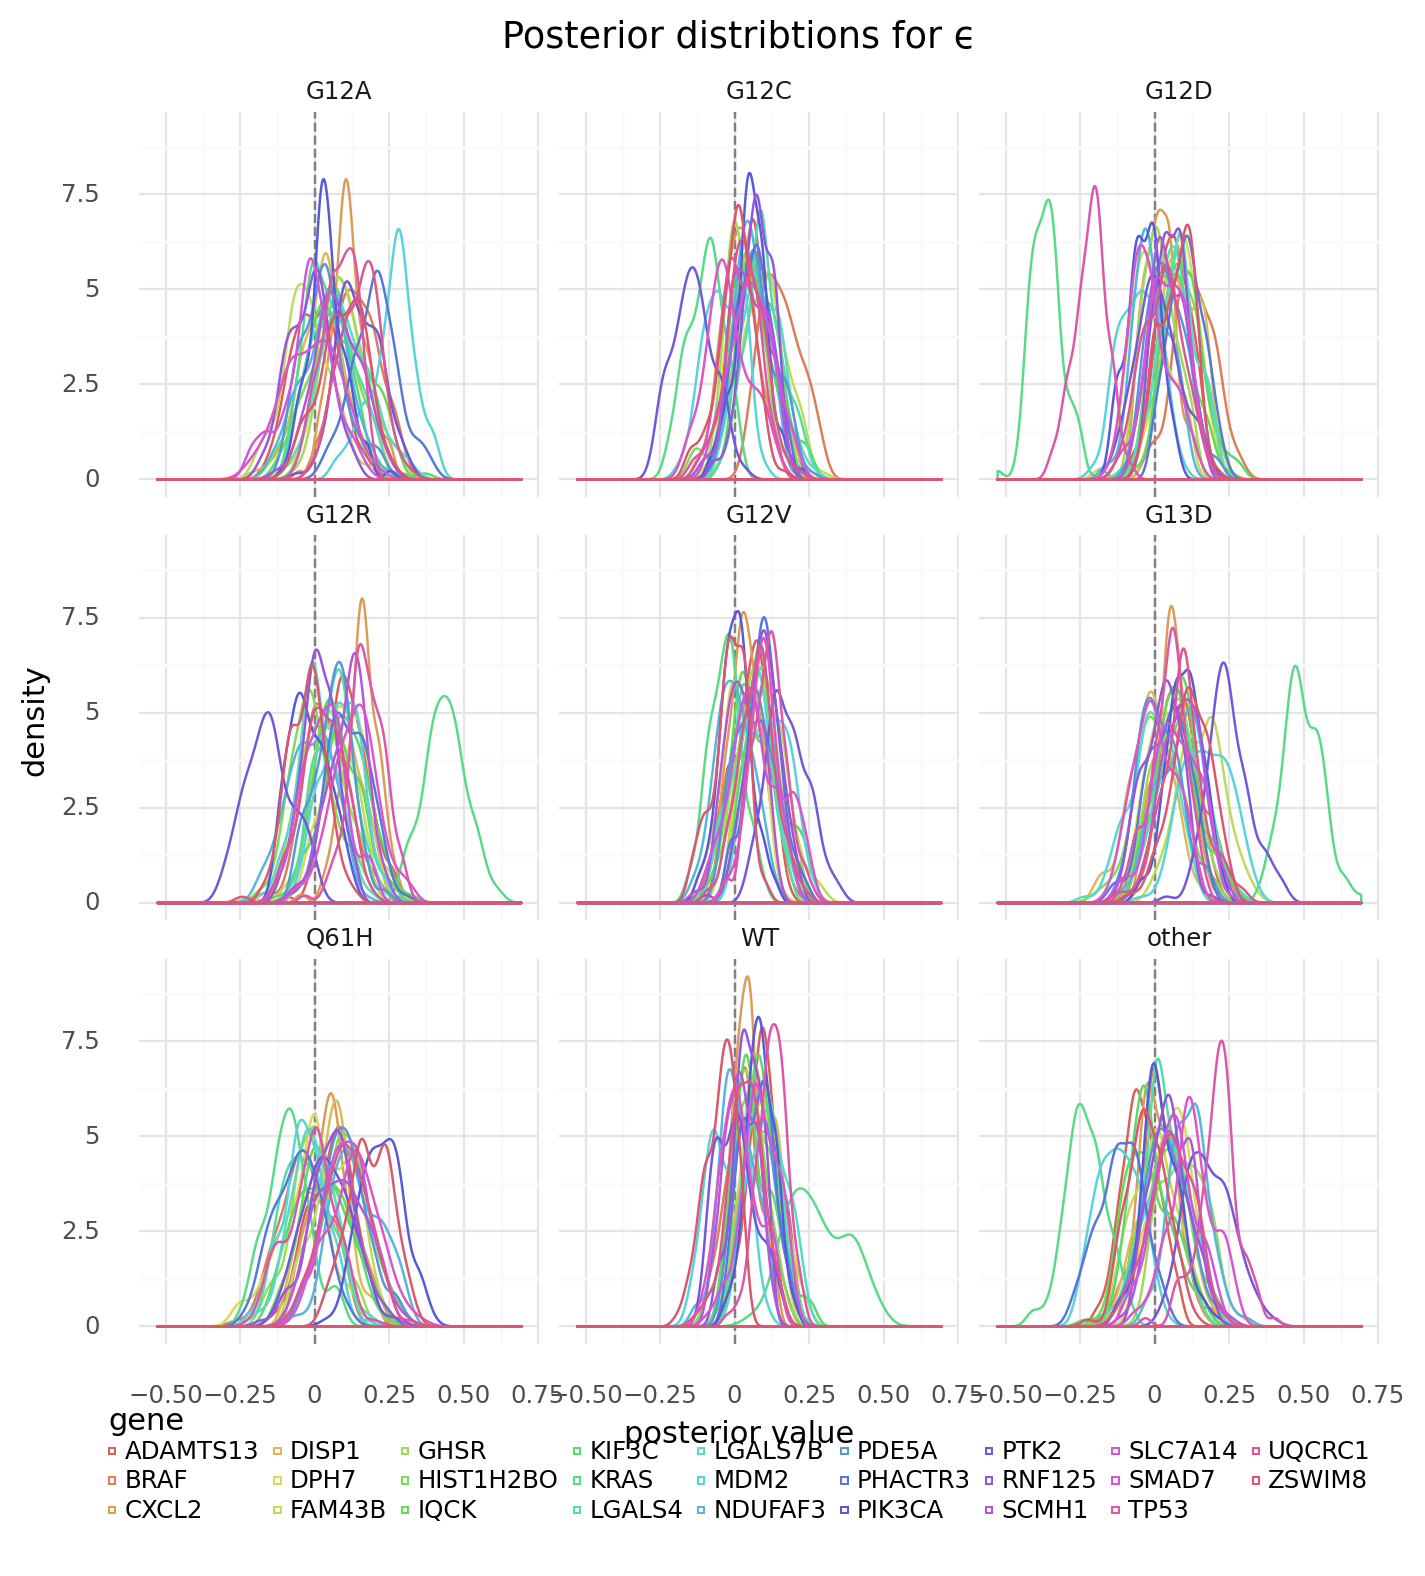

<ggplot: (8770114265995)>

In [101]:
(
    gg.ggplot(m7_epslion_tidy, gg.aes(x="value"))
    + gg.facet_wrap("kras_mutation", ncol=3)
    + gg.geom_vline(xintercept=0, color="grey", linetype="--")
    + gg.geom_density(gg.aes(color="hugo_symbol"))
    + gg.scale_color_discrete(guide=gg.guide_legend(nrow=3))
    + gg.theme(
        figure_size=(8, 8),
        subplots_adjust={"hspace": 0.1, "wspace": 0.05},
        legend_position="bottom",
        legend_key_size=3,
    )
    + gg.labs(
        x="posterior value",
        y="density",
        color="gene",
        title="Posterior distribtions for ϵ",
    )
)

In [82]:
kras_idx = np.where(data.hugo_symbol.values.categories == "KRAS")[0][0]
kras_g_s = m7_sampling_results["trace"]["g_s"][:100, kras_idx]

kras_epslion = m7_epslion_tidy.copy()[m7_epslion_tidy.hugo_symbol == "KRAS"]
kras_epslion["kras_g_s"] = np.tile(kras_g_s, kras_epslion.kras_mutation.nunique())

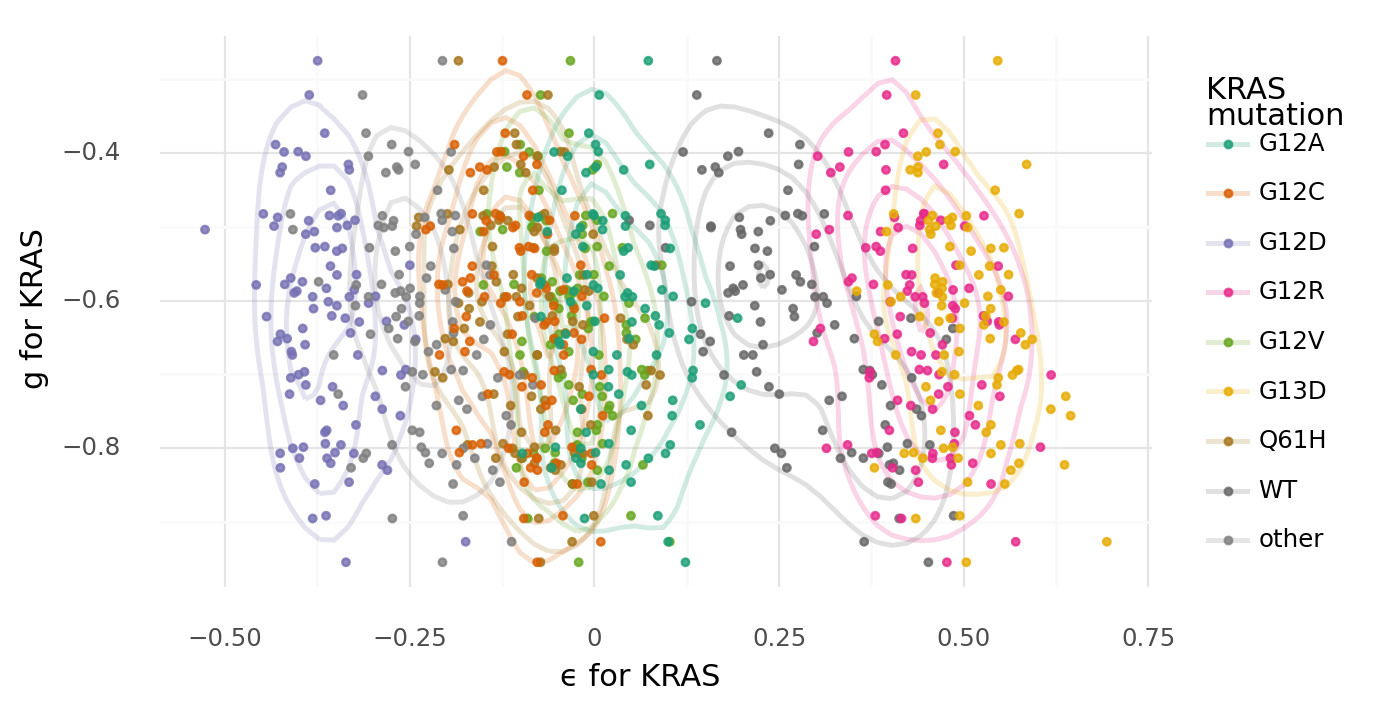

<ggplot: (8769638892710)>

In [94]:
(
    gg.ggplot(kras_epslion, gg.aes(x="value", y="kras_g_s"))
    + gg.geom_density_2d(gg.aes(color="kras_mutation"), alpha=0.2, size=1)
    + gg.geom_point(gg.aes(color="kras_mutation"), alpha=0.8, size=1)
    + gg.scale_color_brewer(type="qual", palette="Dark2")
    + gg.coord_equal()
    + gg.labs(x="ϵ for KRAS", y="g for KRAS", color="KRAS\nmutation")
)

---

In [6]:
notebook_toc = time()
print(f"execution time: {(notebook_toc - notebook_tic) / 60:.2f} minutes")

execution time: 0.13 minutes


In [7]:
%load_ext watermark
%watermark -d -u -v -iv -b -h -m

Last updated: 2021-01-25

Python implementation: CPython
Python version       : 3.9.1
IPython version      : 7.19.0

Compiler    : GCC 9.3.0
OS          : Linux
Release     : 3.10.0-1062.el7.x86_64
Machine     : x86_64
Processor   : x86_64
CPU cores   : 28
Architecture: 64bit

Hostname: compute-e-16-231.o2.rc.hms.harvard.edu

Git branch: data-subset-model

plotnine  : 0.7.1
re        : 2.2.1
pandas    : 1.2.0
matplotlib: 3.3.3
numpy     : 1.19.5
pymc3     : 3.9.3
theano    : 1.0.5
arviz     : 0.11.0

